In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
import pandas as pd
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
from plotting import plot_linestring, plot_polygon
from heuristics import euclidean_distance
from planning_utils import a_star, heuristic, create_grid
from udacidrone.frame_utils import global_to_local, local_to_global
from skimage.morphology import medial_axis
from skimage.util import invert

In [4]:
from planning_engines import get_main_plan, get_global_home, get_medial_axis_path

In [19]:
filename='colliders.csv'
global_home = get_global_home(filename)
global_position=np.array([-122.3943410,37.7915164, 0])
current_local_pos = global_to_local(global_position, global_home)

#goal_lon, goal_lat = -122.39441123, 37.79141968 # main str between mission and howard
goal_lon, goal_lat = -122.398721, 37.7931154  # front street (a block from McDonalds)

TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 3

In [20]:
path, data, north_offset, east_offset = get_main_plan(global_home, goal_lat, goal_lon, current_local_pos)

North offset = 316, east offset = 445
Local Goal: {0}
Local Start and Goal:  (210, 719) (385, 332)
Found a path.
number of waypoints: 546
number of waypoints after pruning: 201
number of waypoints after collinearity pruning: 201
number of waypoints after raytracing pruning: 16


In [21]:
# reverse to grid coordinates
path = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]

In [22]:
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
grid, nmin, emin = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
north_offset = -1 *nmin
east_offset = -1*emin

In [23]:
print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

North offset = 316, east offset = 445


In [24]:
grid_start = (int(current_local_pos[0] + north_offset), int(current_local_pos[1] + east_offset))
local_goal = global_to_local((goal_lon, goal_lat, 0), global_home)
grid_goal = (local_goal[0] + north_offset, local_goal[1] + east_offset)
print('Local Start and Goal: ', grid_start, grid_goal)


Local Start and Goal:  (210, 719) (385.7769926772453, 332.6409366240259)


In [25]:
_, skeleton = get_medial_axis_path(grid, grid_goal, grid_start)

Found a path.


In [26]:
E, N= 1, 0

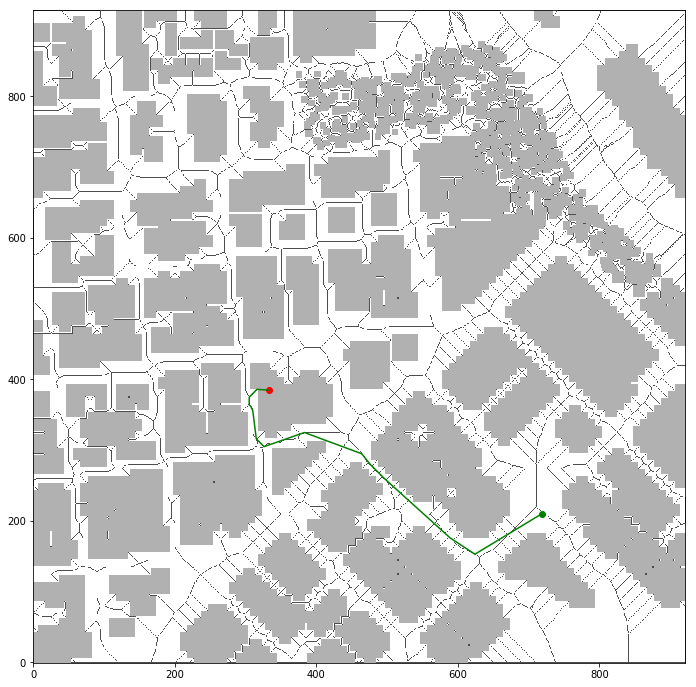

In [27]:
fig, ax = plt.subplots(1,1)
#ax.imshow(grid==0, cmap='gray')
ax.imshow(grid, origin='lower', cmap='Greys') 
ax.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)

_ = ax.plot(grid_start[E], grid_start[N], 'go')
#_ = ax.plot(skel_start[E], skel_start[N], 'gx')
#_ = ax.plot(skel_goal[E], skel_goal[N], 'rx')
_ = ax.plot(grid_goal[E], grid_goal[N], 'ro')
pp = np.array(path)
_ = ax.plot(pp[:,E], pp[:,N], '-', c='green')

In [28]:
from udacidrone import Drone
from datetime import datetime

In [29]:
t_log = Drone.read_telemetry_data("./Logs/FrontStreet_VM_Run_TLog.txt")
t,x,y,z = t_log["MsgID.LOCAL_POSITION"]

In [30]:
local_pos = pd.DataFrame(t_log["MsgID.LOCAL_POSITION"]).T
local_pos.columns= ["t","x", "y", "z"]
local_pos["t"] = local_pos.t.apply(lambda t : datetime.fromtimestamp(t))
local_pos["z"] = local_pos.z * -1
local_pos["north"] = local_pos["x"] + north_offset
local_pos["east"] = local_pos["y"] + east_offset

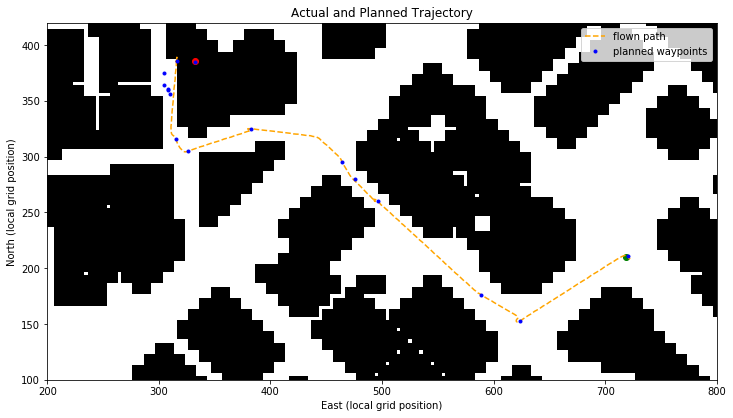

In [31]:
fig, ax = plt.subplots(1,1)
#ax.imshow(grid==0, cmap='gray')
ax.imshow(grid, origin='lower', cmap='Greys') 

_ = ax.plot(grid_start[E], grid_start[N], 'go')
_ = ax.plot(grid_goal[E], grid_goal[N], 'ro')

#local_pos.plot.scatter(x="east", y="north", ax=ax)
_ = ax.plot(local_pos.east, local_pos.north, '--', c="orange", label="flown path")
pp = np.array(path)
_ = ax.plot(pp[:,E], pp[:,N], '.', c='blue', label="planned waypoints")
_ = ax.set_title("Actual and Planned Trajectory")
_ = ax.set_xlabel("East (local grid position)")
_ = ax.set_ylabel("North (local grid position)")
_ = ax.set_xlim([200, 800])
_ = ax.set_ylim([100, 420])
ax.legend(loc="best")

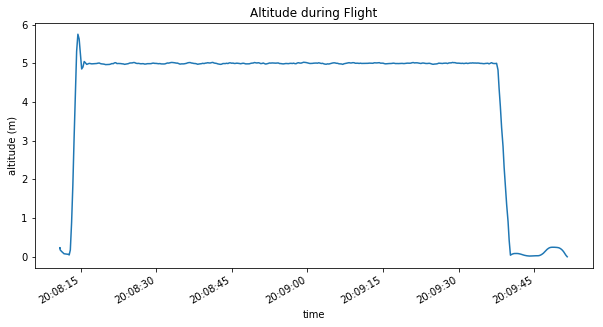

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
local_pos.set_index("t").z.plot(ax=ax)
_ = ax.set_title("Altitude during Flight")
_ = ax.set_xlabel("time")
_ = ax.set_ylabel("altitude (m)")